# ROC曲線

受信者操作特性(Receiver Operator Characteristic: ROC)曲線は、性能に基づいて分類モデルを選択するための便利なツールである。

その際には、分類器のしきい値を変えることによって計算される偽陽性率（FPR）と真陽性率(TPR)が選択の基準となる。

ROC曲線の対角線は当て推量（ランダムな推定）として解釈でき、対角線を下回る分類モデルは当て推量よりも劣ると見なされる。

完璧な分類器はグラフの左上隅に位置付けられ、TPRは1、FPRは0になる。そして、分類モデルの性能を明らかにするために、ROC曲線に基づいて曲線下面積を計算できる。

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# ジュピターノートブック上でグラフを表示させるための処理
%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import  f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from scipy import interp

## Breast Cancer Wisconsinデータセットの読み込み

このデータセットには、悪性腫瘍細胞と良性腫瘍細胞の569のサンプルが含まれている。

このデータセットの最初の2つの列には、サンプルの一意なIDとそれに対応する診断結果が含まれている。診断結果の`M`は悪性(malignant)を示し、`B`は良性(benign)を示す。

3列目から32列目には、細胞核のデジタル画像から算出された30個の実数値の特徴量が含まれている。

これらは腫瘍が良性か悪性かを予測するモデルの構築に利用できる。

In [2]:
# データセットの読み込み
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
# 30個の特徴量をnumpy配列のオブジェクトXに割り当てる。
# LabelEncoderを使って、元のクラスラベルの文字列表現(MおよびB)を整数に変換する。
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
# 配列yに格納されたクラスラベル（診断結果）エンコードした後は、悪性腫瘍はクラス1、良性腫瘍はクラス2で表される。
y = le.fit_transform(y)
print(y[:5])
print(le.fit_transform(['M', 'B']))

# エンコード後のデータセットをトレーニングデータセット（データの80%）とテストデータセット（データの20%）に分割する。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

[1 1 1 1 1]
[1 0]


## 腫瘍が良性か悪性かを予測する分類器のROC曲線をプロット

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


TypeError: object of type 'generator' has no len()

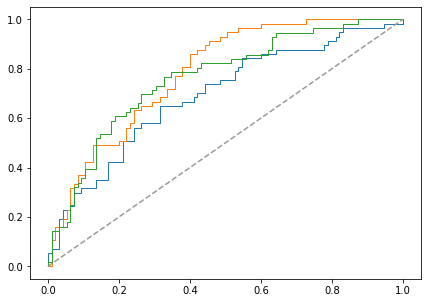

In [9]:
# スケーリング、主成分分析、ロジスティック回帰を指定して、Pipelineクラスをインスタンス化
pipe_lr = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components=2)), ('clf', LogisticRegression(penalty='l2', random_state=0, C=100.0))])

# 2つの特徴量を抽出
X_train2 = X_train[:, [4, 14]]

#層化k分割交差検証イテレータを表すStratifiedKFoldクラスをインスタンス化
cv = StratifiedKFold(n_splits=3, random_state=1).split(X=X_train2, y=y_train)
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0

# 0から1までの間で100個の要素を生成
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    # predict_probaメソッドで確率を予測、fitメソッドでモデルに適合させる
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    
    # roc_curve関数でROC曲線の性能を計算していプロット
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    
    # FPR(X軸)とTPR(Y軸)を線形補間
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    
    # 曲線下面積(AUC)を計算
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
    
# 当て推量をプロット
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')
    
# FPR、TPR、ROC、AUCそれぞれの平均を計算してプロット
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='mean ROC(area = %0.2f)' % mean_auc, lw=2)

# 完全に予測が正解したときのROC曲線をプロット
plt.plot([0, 0, 1],
        [0, 1, 1],
        lw=2,
        linestyle=':',
        color='black',
        label='prefect performance')

# グラフの各項目を指定
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Charateristic')
plt.legend(loc="lower right")
plt.show()

